In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [5]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
X.shape

(41654, 71)

In [8]:
Y.shape

(41654, 4)

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=1)

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
if not os.path.exists('../data/log_reg/multiclass_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/multiclass_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/multiclass_probs.npy')

Epoch 1/700
37488/37488 [==============================] - 1s - loss: 2.5870 - acc: 0.3568     
Epoch 2/700
37488/37488 [==============================] - 0s - loss: 2.6443 - acc: 0.3603     
Epoch 3/700
37488/37488 [==============================] - 0s - loss: 2.6432 - acc: 0.3601     
Epoch 4/700
37488/37488 [==============================] - 0s - loss: 2.6433 - acc: 0.3604     
Epoch 5/700
37488/37488 [==============================] - 0s - loss: 2.6444 - acc: 0.3605     
Epoch 6/700
37488/37488 [==============================] - 0s - loss: 2.6438 - acc: 0.3603     
Epoch 7/700
37488/37488 [==============================] - 0s - loss: 2.6441 - acc: 0.3603     
Epoch 8/700
37488/37488 [==============================] - 0s - loss: 2.6436 - acc: 0.3607     
Epoch 9/700
37488/37488 [==============================] - 0s - loss: 2.6435 - acc: 0.3607     
Epoch 10/700
37488/37488 [==============================] - 0s - loss: 2.6442 - acc: 0.3604     
Epoch 11/700
37488/37488 [=============

KeyboardInterrupt: 

In [14]:
probabilities = np.load('../data/log_reg/multiclass_probs.npy')

In [15]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [16]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [17]:
metrics.accuracy_score(Y, predicted_transformed)

0.74797138330052337

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [18]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.71      0.70      0.71     14589
          1       0.49      0.18      0.26      1600
          2       0.63      0.63      0.63      4309
          3       0.80      0.85      0.82     21156

avg / total       0.74      0.75      0.74     41654



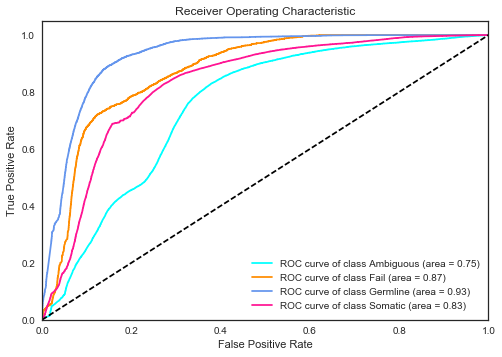

In [19]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00089957  0.0035822   0.00459466  0.00629871  0.00845529  0.00863959
  0.01109931  0.01290466  0.01475754  0.01565947]


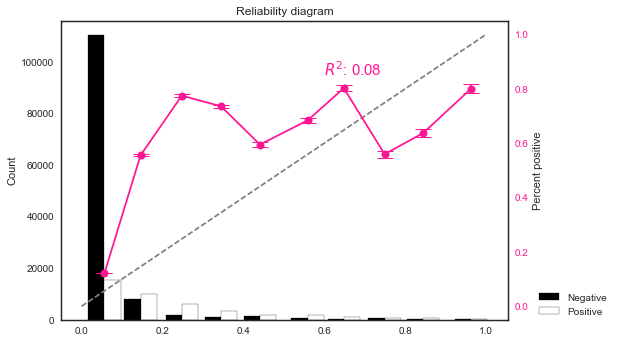

In [20]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 'deeppink')

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [21]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [6]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [ ]:
training_data.groupby('binary_call').size()

In [ ]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [ ]:
X.shape

In [ ]:
binary_Y.shape

In [ ]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [ ]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [ ]:
if not os.path.exists('../data/log_reg/binary_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/log_reg/binary_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/log_reg/binary_probs.npy')

In [ ]:
binary_probabilities

In [ ]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [ ]:
metrics.accuracy_score(binary_Y, predicted)

In [ ]:
print(metrics.classification_report(binary_Y, predicted))

In [ ]:
somatic_prob = binary_probabilities[:,1]

In [ ]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'deeppink')

# Somatic, ambigous, fail classifier

In [7]:
three_class = training_data.replace('g', 'f')
three_class.call.value_counts()

s    21156
a    14589
f     5909
Name: call, dtype: int64

In [8]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [9]:
X.shape

(41654, 71)

In [10]:
Y.shape

(41654, 3)

In [11]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [12]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(3, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
if not os.path.exists('../data/log_reg/threeclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/threeclass_relu_probs.npy')

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.75493349978393431

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.73      0.66      0.70     14589
          1       0.60      0.66      0.63      5909
          2       0.82      0.84      0.83     21156

avg / total       0.76      0.75      0.75     41654



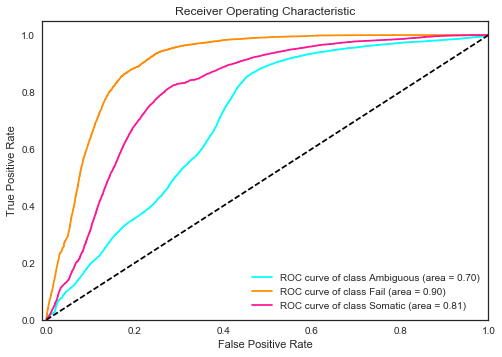

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'deeppink', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00127809  0.00394568  0.0056964   0.00669435  0.0069126   0.00783494
  0.00816708  0.00998142  0.00819338  0.0057043 ]


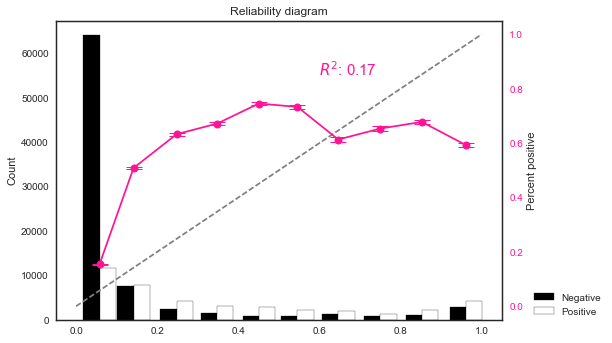

In [20]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'deeppink')